In [1]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st
import os
sns.set_style("darkgrid")

# Settare vuota questa variabile oppure impostare la prorpia cartella di lavoro
wdir = r"D:\Python\Casual\Machine_Learning\DataFoundamentalsProject\fundamentals"

In [2]:
df = pd.read_csv(os.path.join(wdir, "IRIS.csv"), engine="c")

# Analisi Esplorativa
---

In [ ]:
df.info()

Visualizzazione parziale del dataset giusto per farsi un'idea

In [ ]:
df.head()

Conversione della colonna "species" in category, per coerenza con il tipo di dato

In [ ]:
df.species = df["species"].astype("category")

La colonna "species" rappresenta il target della classificazione, è utile capire quante classi occorre verificare

In [ ]:
df.species.unique().tolist()

Descrizione generale del dataset

In [ ]:
df.describe()

# Analisi Descrittiva
---

Numerosità di ogni classe:
* Si nota che per ogni classe la numerosità è la stessa

In [ ]:
catplot = sns.catplot(data=df, x='species', kind='count')

catplot.savefig(os.path.join(wdir, "class_count.png"))

Realizzazione di un PairPlot per avere un'idea delle relazioni che intercorrono tra le variabili, con l'aggiunta di un boxplot sulla diagonale per verificare la presenza di outliers

In [ ]:
grid = sns.PairGrid(df, hue='species')
grid.map_diag(sns.boxplot)
grid.map_offdiag(sns.scatterplot)
grid.add_legend()
grid.savefig(os.path.join(wdir, "pairplot.png"))

Vi è una correlazione positiva tra le seguenti features:
* petal_lenght e sepal_length
* petal_width e sepal_length
* petal_width e petal_length

Si procede con un ulterirore analisi sui boxplots 

In [ ]:
species = df['species'].unique()
features = df.columns[:-2]

# Creazione di una griglia 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# Per ogni specie assegno un colore
col_colors = sns.color_palette("husl", n_colors=len(species))

# Creazione dei boxplot
for i, feature in enumerate(features):
    for j, specie in enumerate(species):
        current_data = df[df['species'] == specie]
        sns.boxplot(data=current_data, y=feature,ax=axes[i, j], color=col_colors[j])
        axes[i, j].set_title(f"{specie.replace('Iris-', '').upper()} - Curtosi={round(st.describe(current_data[feature]).kurtosis, 5)} - Skewness={round(st.describe(current_data[feature]).skewness, 5)}")
    
        # Aggiungo un punto di riferiemnto per la media
        axes[i, j].scatter(0, current_data[feature].mean(), color='red', zorder=3)


# Aggiusta lo spaziamento tra i subplot
plt.tight_layout()
fig.savefig(os.path.join(wdir, "boxplots.png"))

Nel complesso le distribuzioni mostrano un andamento pressocché normale senza forti asimmetrie. Si nota la presenza di probabili outliers in alcuni boxplots. Per completezza si riportano i relativi istogrammi

In [ ]:
species = df['species'].unique()
features = df.columns[:-2]

# Creazione di una griglia 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# Per ogni specie assegno un colore
col_colors = sns.color_palette("husl", n_colors=len(species))

for i, feature in enumerate(features):
    for j, specie in enumerate(species):
        current_data = df[df['species'] == specie]
        sns.histplot(data=current_data, x=feature, ax=axes[i, j], color='skyblue', kde=True) # kde mette in sovraimpressione la curva
        axes[i, j].set_title(f'{feature} vs {specie}')
        axes[i, j].set_title(f"{specie.replace('Iris-', '').upper()} - Curtosi={round(st.describe(current_data[feature]).kurtosis, 5)} - Skewness={round(st.describe(current_data[feature]).skewness, 5)}")

# Aggiusta lo spaziamento tra i subplot
plt.tight_layout()
fig.savefig(os.path.join(wdir, "histos.png"))

#### Correlation Matrix
---
Una misura quantitativa di quanto ciascuna variabile sia correlata ad un'altra si ottiene calcolando la matrice di correlazione. Di fatto si determina la covarianza tra ogni coppia di variabili e si crea una matrice per visualizzare comodamente ogni coppia. Tenendo conto che una buona correlazione si ha se l'entrata della matrice è in modulo pressocché pari ad 1. 

In [ ]:
corr_matrix = df.drop(["species"], axis=1).corr()

plt.figure(figsize=(8, 6))
# Mappa di colori personalizzata
sns.heatmap(corr_matrix, annot=True, cmap='viridis_r')
plt.savefig(os.path.join(wdir, "corr_matrix.png"))

Si riconfermano le correlazioni tra le features notate nel Pairgrid. Per completezza si realizza un grafico in cui vengono rappresentate le tre rette di regressione

In [ ]:
# Variabili da plottare
coupled_vars = [('petal_width', 'petal_length'), ('petal_width', 'sepal_length'), ('petal_length', 'sepal_length')]

# Griglia
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Colori per le rette di regressione
palette = sns.color_palette("husl", n_colors=len(coupled_vars))

# Rette di regressione
for i, (x_var, y_var) in enumerate(coupled_vars):
    # Punti colorati in base alla specie
    sns.scatterplot(x=x_var, y=y_var, hue='species', data=df, ax=axes[i], palette='Set1')
    
    # Retta di regressione con statsmodels
    X = sm.add_constant(df[x_var])
    linmod = sm.OLS(df[y_var], X)
    res = linmod.fit()
    slope = res.params[x_var]
    intercept = res.params['const']
    r_squared = res.rsquared
    
    # Plot della retta di regressione
    x_values = np.array([df[x_var].min(), df[x_var].max()]) # estraggo i due punti più estremi per tracciare la retta
    y_values = intercept + slope * x_values
    axes[i].plot(x_values, y_values, color=palette[i], linestyle='-', linewidth=4)
    
    # Titolo del grafico
    axes[i].set_title(f'Pendenza = {slope:.2f} - Intercetta = {intercept:.2f} - R² = {r_squared:.2f}')
    axes[i].legend()

plt.tight_layout()
fig.savefig(os.path.join(wdir, "regressione.png"))

Si osserva dunque una correlazione positiva per ogni coppia di variabili, con un R² pressocché pari ad 1. Si ricorda inoltre che la pendenza rappresenta la variazione media subita da Y quando X aumenta di un'unità

# Setup del modello
---

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay

#### Pre-processing dei dati

In [4]:
# Split del dataset in train and test
df_no_target = df.iloc[:, :-1]
target = df.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(df_no_target, target, test_size=0.2, random_state=30)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [5]:
# Standardizzazione dei dati
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

### PCA
---
Riduzione la dimensionalità del dataset

In [6]:
pca = PCA(n_components = 4)
X_train_standard_pca = pca.fit_transform(X_train_standard)
X_test_standard_pca = pca.transform(X_test_standard)

Grafico cumulativo della varianza spiegata dalle 4 PC

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Indice componenti')
plt.ylabel('Varianza cumulata')
plt.grid(True)
plt.savefig(os.path.join(wdir, "cumulative_var.png"))

Realizzazione dello Scree plot

In [ ]:
# Estrae gli autovalori ossia la varianza spiegata da ciascuna componente
eigenvalues = pca.singular_values_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.xlabel('Indice Componenti Principali')
plt.ylabel('Autovalori / Varianza')
plt.title('Scree Plot')
plt.grid(True)

Dai grafici si nota come le prime due componenti spiegano poco più del 95% della varianza del dataset. Per cui considerare solo loro durante l'addestramento del modello non comporta una perdita significativa di informazioni

Realizzazione del Biplot

<Axes: title={'center': 'Spazio delle componenti principali'}, xlabel='Dimension 1', ylabel='Dimension 2'>

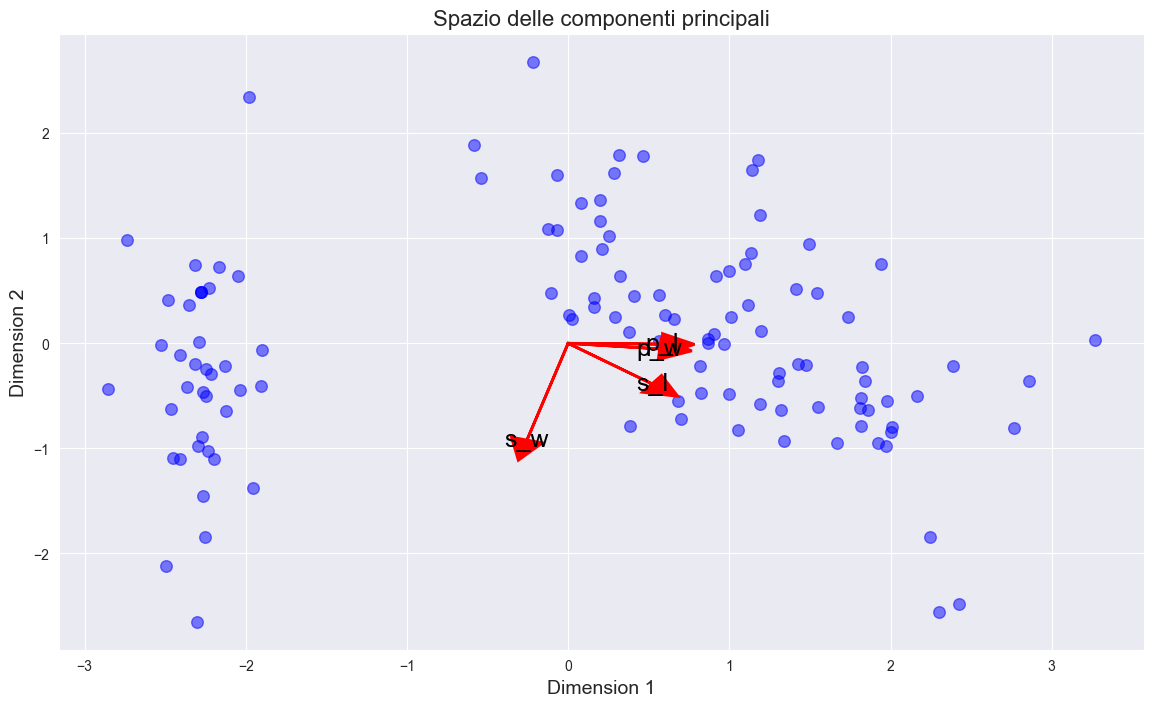

In [20]:
def biplot(levels, scores, pca):
    fig, ax = plt.subplots(figsize = (14,8))
    
    # Scatterplot degli scores
    ax.scatter(x=scores[:, [0]], y=scores[:, [1]], facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    # Estrazione dei loadings
    loadings = pca.components_.T

    for index, loading in enumerate(loadings):
        
        ax.arrow(0, 0, loading[0], loading[1],
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(loading[0], loading[1], str(levels[index]).split("_")[0][0] + "_" + str(levels[index]).split("_")[1][0], color='black',
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("Spazio delle componenti principali", fontsize=16)
    fig.savefig(os.path.join(wdir, "biplot.png"))
    return ax

biplot(df_no_target.columns, X_train_standard_pca, pca)

Si nota che le features "petal_length" e "petal_width" sono spiegate dalla seconda componente principale. La feature "sepal_lentgh" è spiegata più dalla seconda che dalla prima componente. Infine l'ultima feature forma un angolo retto con "sepal_length" per cui non sono correlate, mentre viene spiegata dalle due componenti principali in maniera più o meno equa.

### Addestramento
---

-----LINEAR-----
* accuracy:  0.93333
* f1 score:  0.93250
* confusion_matrix: 
[[12  0  0]
 [ 0  7  2]
 [ 0  0  9]]
-----POLY-----
* accuracy:  0.90000
* f1 score:  0.89969
* confusion_matrix: 
[[12  0  0]
 [ 0  8  1]
 [ 0  2  7]]
-----RBF-----
* accuracy:  0.93333
* f1 score:  0.93250
* confusion_matrix: 
[[12  0  0]
 [ 0  7  2]
 [ 0  0  9]]


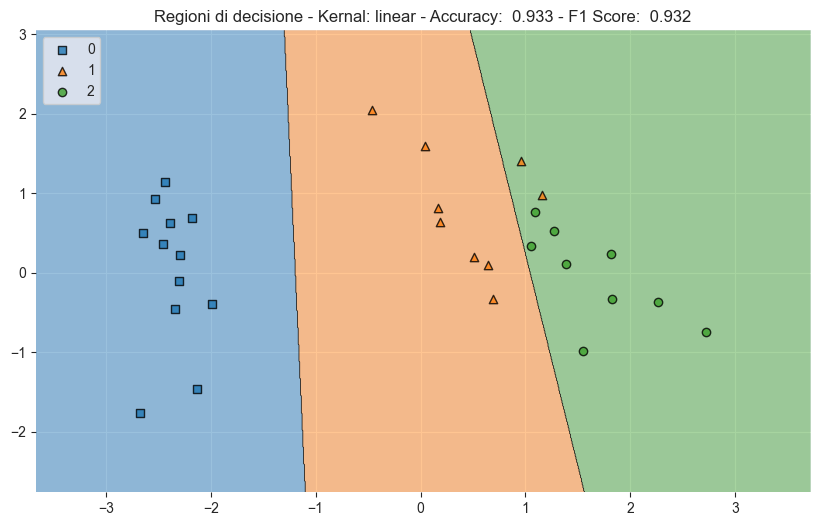

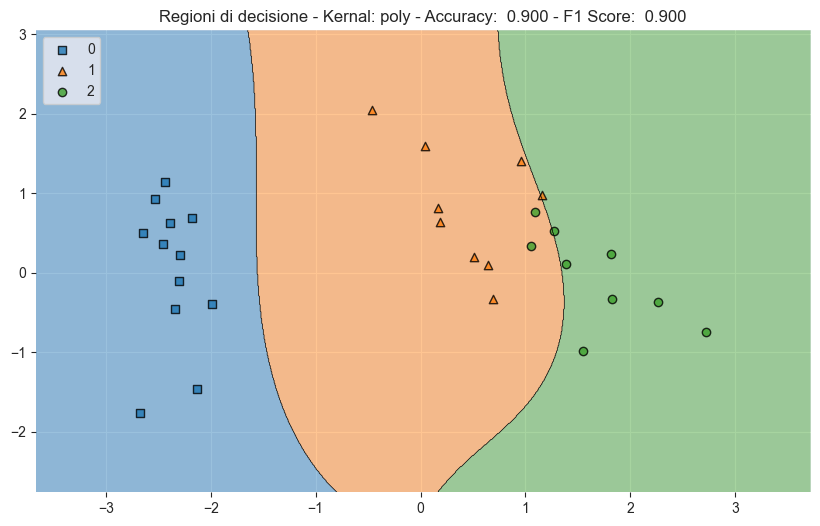

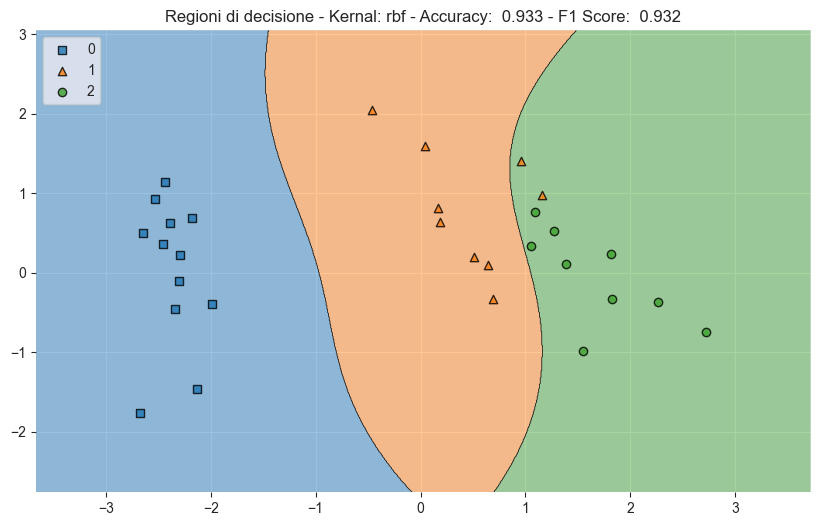

In [21]:
# Si considerano solo le prime 2 PC
X_train_standard_pca_filtered = X_train_standard_pca[:, :-2]
X_test_standard_pca_filtered = X_test_standard_pca[:, :-2]

# Differenti kernel
kernels = ["linear", "poly", "rbf"]
performaces = dict()
class_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
# Conversione delle classi in valori numerici
y_train_int = np.array([class_mapping[cls] for cls in y_train])
y_test_int = np.array([class_mapping[cls] for cls in y_test])

for kernel in kernels:
    
    # Training del modello
    model = SVC(kernel=kernel)
    model.fit(X_train_standard_pca_filtered, y_train_int)
    
    
        # Valutazione performance del modello
    y_pred = model.predict(X_test_standard_pca_filtered)
    
        # Confusion Matrix
    cm = confusion_matrix(y_test_int, y_pred)
    
        # F1 Score
    f1 = f1_score(y_test_int, y_pred, average='weighted')
    
        # Accuracy
    accuracy = accuracy_score(y_test_int, y_pred)
    
    
    performaces[kernel] = {"accuracy": accuracy, "f1 score": f1, "confusion_matrix": cm}
    

    # Tracciamento del confine decisionale sul test set
    plt.figure(figsize=(10, 6))
    plt.title(f"Regioni di decisione - Kernal: {kernel} - Accuracy: {accuracy : .3f} - F1 Score: {f1 : .3f}")
    plot_decision_regions(X_test_standard_pca_filtered, y_test_int, clf=model, zoom_factor=1)
    plt.legend(loc='upper left')
    plt.savefig(os.path.join(wdir, f"region of {kernel}.png"))
    



output = """"""
for kernel in performaces.keys():
    output += f"-----{kernel.upper()}-----\n"
    metrics = performaces[kernel]
    for metrica in metrics.keys():
        output += f"* {metrica}: {metrics[metrica] : .5f}\n" if metrica != "confusion_matrix" else f"* {metrica}: \n{metrics[metrica]}\n"

print(output)

### Matrice di confusione
---
Mostra graficamente l'F1 score

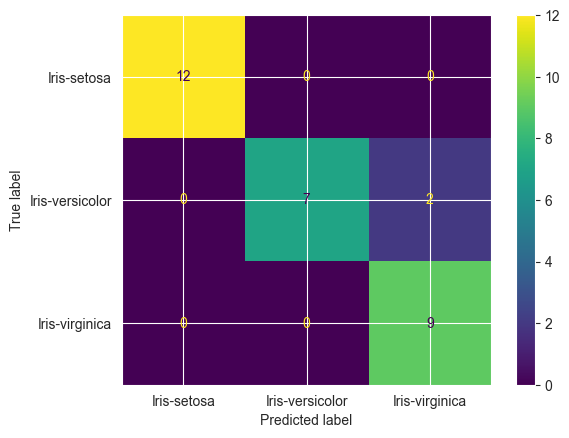

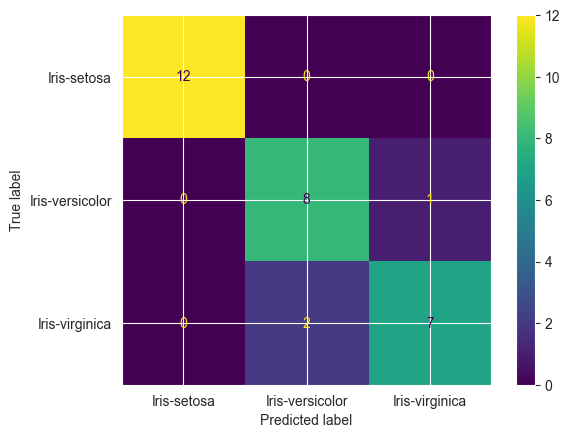

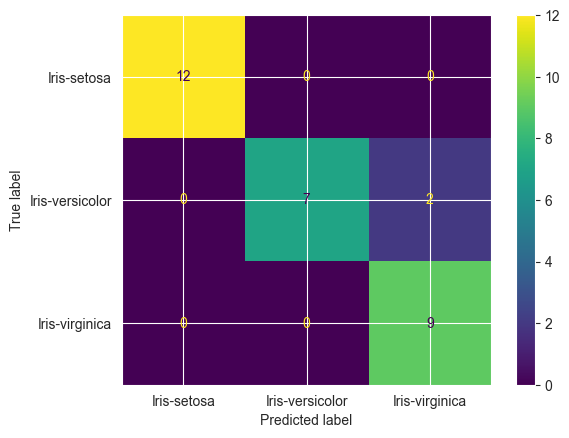

In [22]:
for kernel in performaces.keys():
    metrics = performaces[kernel]
    current_cm = metrics["confusion_matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=current_cm, display_labels=list(class_mapping.keys()))
    disp.plot()
    plt.savefig(os.path.join(wdir, f"cm of {kernel}.png"))